Feature Extraction and Engineering

In [50]:
import pandas as pd
import numpy as np


In [51]:
# Load the dataset
data = pd.read_csv(r'C:\Users\rithv\OneDrive\Desktop\cnn_rnn_models\mosquito_resdev\mtmbiochemassdata.csv')  # Replace with your data file path


In [52]:
# Extract relevant columns
geographical_data = data[['LATITUDE', 'LONGITUDE']]
resistance_data = data['MECHANISM_STATUS']
species_data = data['VECTOR SPECIES']

In [53]:

import geopy 
from geopy.distance import geodesic

# Example central coordinates
central_coordinates = (7.881, 19.3551)

# Calculate distances to central point
data['DISTANCE_TO_CENTRAL'] = data.apply(lambda row: geodesic(central_coordinates, (row['LATITUDE'], row['LONGITUDE'])).kilometers, axis=1)


In [54]:
from sklearn.cluster import KMeans

# Example: K-Means with 5 clusters
kmeans = KMeans(n_clusters=5)
data['GEO_CLUSTER'] = kmeans.fit_predict(data[['LATITUDE', 'LONGITUDE']])


c:\Users\rithv\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [55]:
# # Define grid dimensions
# grid_size = 0.1  # Adjust the grid size as needed

# # Create grid cells based on latitude and longitude
# data['GRID_CELL_LAT'] = (data['LATITUDE'] // grid_size) * grid_size
# data['GRID_CELL_LON'] = (data['LONGITUDE'] // grid_size) * grid_size

# from sklearn.preprocessing import LabelEncoder

# # Create a label encoder
# label_encoder = LabelEncoder()

# # Fit and transform the 'GRID_CELL' column
# data['GRID_CELL'] = data['GRID_CELL_LAT'].astype(str) + '_' + data['GRID_CELL_LON'].astype(str)
# data['GRID_CELL_ENCODED'] = label_encoder.fit_transform(data['GRID_CELL'])


In [56]:
data['MECHANISM_BINARY'] = (data['MECHANISM_STATUS'] == 'Detected').astype(int)


In [57]:
species_encoded = pd.get_dummies(data['VECTOR SPECIES'], prefix='SPECIES')
data = pd.concat([data, species_encoded], axis=1)


In [58]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['SPECIES_LABEL'] = le.fit_transform(data['VECTOR SPECIES'])


In [59]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['SPECIES_LABEL'] = le.fit_transform(data['VECTOR SPECIES'])


In [60]:
# Save the dataset with extracted features to a new CSV file
data.to_csv('mosquito_data_with_features.csv', index=False)


In [62]:
# Extracted and engineered feature columns
extracted_feature_columns = ['LATITUDE', 'LONGITUDE', 'DISTANCE_TO_CENTRAL', 'GEO_CLUSTER', 'MECHANISM_BINARY', 'SPECIES_LABEL']

# Create a new DataFrame with only the extracted and engineered features
extracted_features_data = data[extracted_feature_columns]

# Save the new DataFrame to a CSV file
extracted_features_data.to_csv('extracted_features.csv', index=False)

Model Building

In [63]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the extracted features dataset
data = pd.read_csv('extracted_features.csv')

# Define the features (X) and the target (y)
X = data.drop(columns=['MECHANISM_BINARY'])  # Exclude the target column
y = data['MECHANISM_BINARY']  # Target column (binary: Detected or Not Detected)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Check the shapes of the splits
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)


Training set shape: (2401, 5)
Validation set shape: (514, 5)
Test set shape: (515, 5)


In [64]:
# import numpy as np

# # Convert data types if needed
# X_train = np.asarray(X_train, dtype=np.float32)
# y_train = np.asarray(y_train, dtype=np.int64)

# # Check data types and shapes
# print("X_train data type:", type(X_train))
# print("y_train data type:", type(y_train))
# print("X_train shape:", X_train.shape)
# print("y_train shape:", y_train.shape)

In [69]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# Define a custom learning rate scheduler
def learning_rate_scheduler(epoch, lr):
    if epoch < 10:
        return 0.001  # High learning rate for initial epochs
    else:
        return lr * tf.math.exp(-0.1)  # Exponential decay

# Define the FNN model
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(5,)),  # Input layer with 6 features
    keras.layers.Dropout(0.3),  # Dropout layer to prevent overfitting
    keras.layers.Dense(64, activation='relu'),  # Hidden layer with 64 neurons and ReLU activation
    keras.layers.Dropout(0.3),  # Dropout layer
    keras.layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid activation (binary classification)
])

# Compile the model with custom learning rate scheduler
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the learning rate scheduler callback
lr_scheduler = LearningRateScheduler(learning_rate_scheduler)

# Print the model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 128)               768       
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 9089 (35.50 KB)
Trainable params: 9089 (35.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [74]:
# Train the model with learning rate scheduling
history = model.fit(X_train, y_train, 
                    epochs=6000,  # You can adjust the number of epochs
                    batch_size=32,  # You can adjust the batch size
                    validation_data=(X_val, y_val),
                    callbacks=[lr_scheduler])


Epoch 1/6000


76/76 [==============================] - 0s 6ms/step - loss: 0.6509 - accuracy: 0.6481 - val_loss: 0.6306 - val_accuracy: 0.6751 - lr: 0.0010
Epoch 2/6000
76/76 [==============================] - 0s 3ms/step - loss: 0.6540 - accuracy: 0.6531 - val_loss: 0.6307 - val_accuracy: 0.6751 - lr: 0.0010
Epoch 3/6000
76/76 [==============================] - 0s 3ms/step - loss: 0.6463 - accuracy: 0.6522 - val_loss: 0.6307 - val_accuracy: 0.6751 - lr: 0.0010
Epoch 4/6000
76/76 [==============================] - 0s 2ms/step - loss: 0.6486 - accuracy: 0.6531 - val_loss: 0.6308 - val_accuracy: 0.6751 - lr: 0.0010
Epoch 5/6000
76/76 [==============================] - 0s 2ms/step - loss: 0.6576 - accuracy: 0.6543 - val_loss: 0.6244 - val_accuracy: 0.6751 - lr: 0.0010
Epoch 6/6000
76/76 [==============================] - 0s 3ms/step - loss: 0.6533 - accuracy: 0.6593 - val_loss: 0.6231 - val_accuracy: 0.6751 - lr: 0.0010
Epoch 7/6000
76/76 [==============================] - 0s 2ms/step - loss: 0.6455 - 

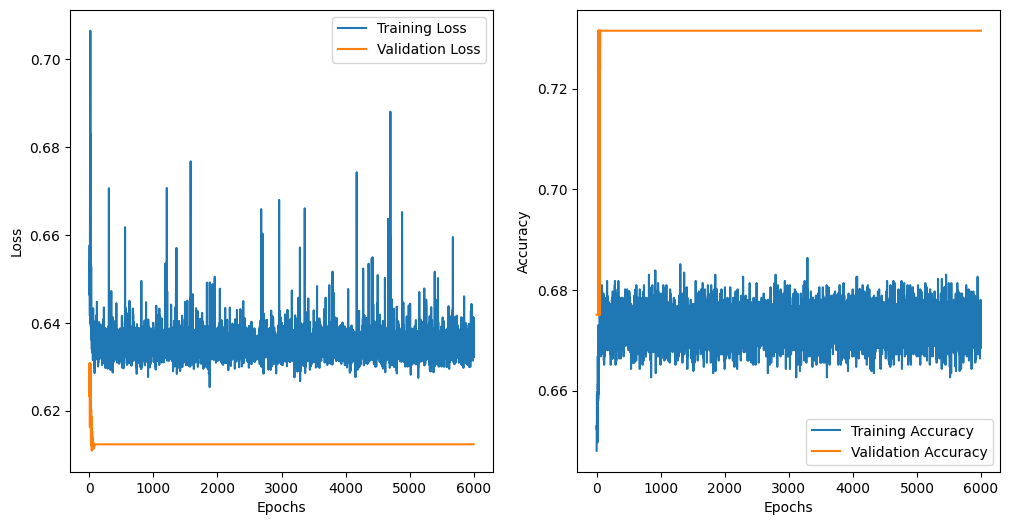

In [75]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [76]:
input_1 = [6.5333, 2.6667, 1849.03, 0, 1]
input_2 = [6.7072, 2.4964, 1865.99, 0, 2]
input_3 = [-0.1726, 34.9198, 1943.37, 2, 3]
input_4 = [8.1234, 7.5678, 2000.0, 1, 4] 


In [77]:
input_5 = [-5.4321, -3.2109, 1600.5, 4, 0]

In [80]:
# # Predictionns using the model
# predictions = model.predict(np.array([input_1, input_2, input_3, input_4, input_5]))

# # Define labels for mosquito resistance
# resistance_labels = ["No Resistance Detected", "Resistance Detected"]

# # Define input data for the examples
# input_data = [
#     {"Latitude": input_1[0], "Longitude": input_1[1], "Distance to Central": input_1[2], "Species": input_1[5]},
#     {"Latitude": input_2[0], "Longitude": input_2[1], "Distance to Central": input_2[2], "Species": input_2[5]},
#     {"Latitude": input_3[0], "Longitude": input_3[1], "Distance to Central": input_3[2], "Species": input_3[5]},
#     {"Latitude": input_4[0], "Longitude": input_4[1], "Distance to Central": input_4[2], "Species": input_4[5]},
#     {"Latitude": input_5[0], "Longitude": input_5[1], "Distance to Central": input_5[2], "Species": input_5[5]},
# ]

# # Interpret and print the predictions with additional information
# for i, pred in enumerate(predictions):
#     print(f"Example {i + 1}:")
#     print(f"Latitude: {input_data[i]['Latitude']:.4f}")
#     print(f"Longitude: {input_data[i]['Longitude']:.4f}")
#     print(f"Distance to Central: {input_data[i]['Distance to Central']:.2f} km")
#     print(f"Species: {input_data[i]['Species']}")
    
#     if pred >= 0.5:
#         print(f"Prediction: {resistance_labels[1]}")
#     else:
#         print(f"Prediction: {resistance_labels[0]}")
    
#     print(f"Confidence: {pred[0]:.4f}\n")

1/1 [==============================] - 0s 29ms/step


IndexError: list index out of range

1/1 [==============================] - 0s 29ms/step


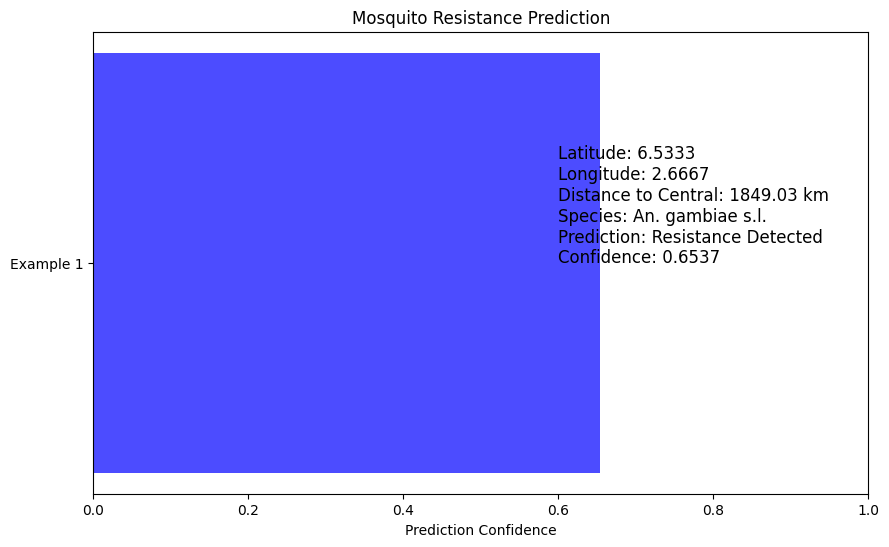

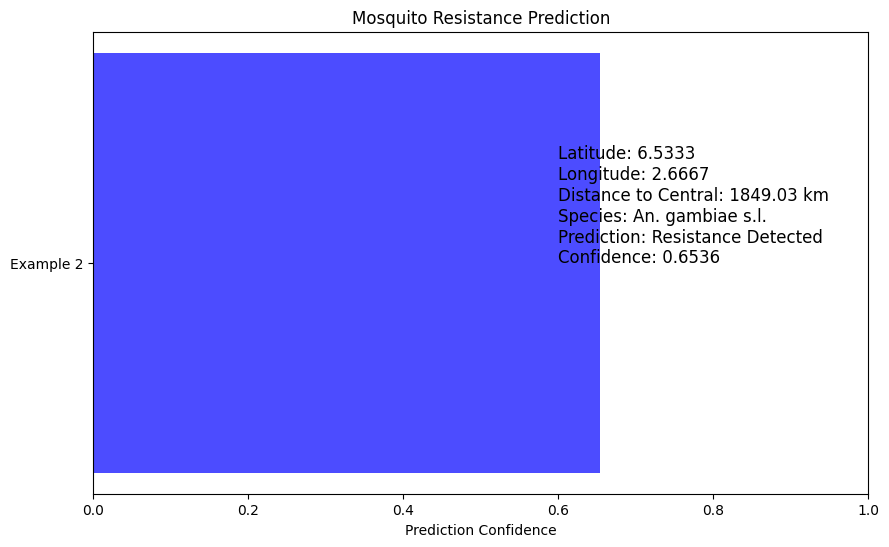

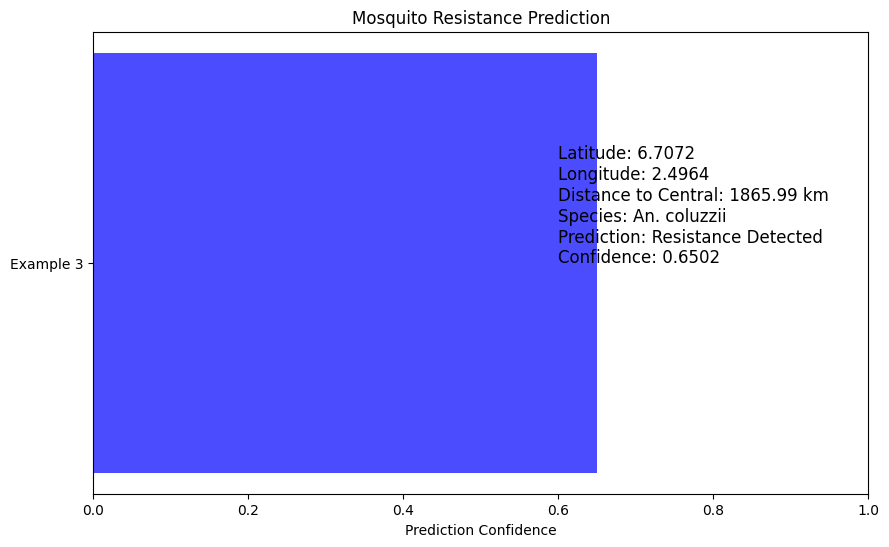

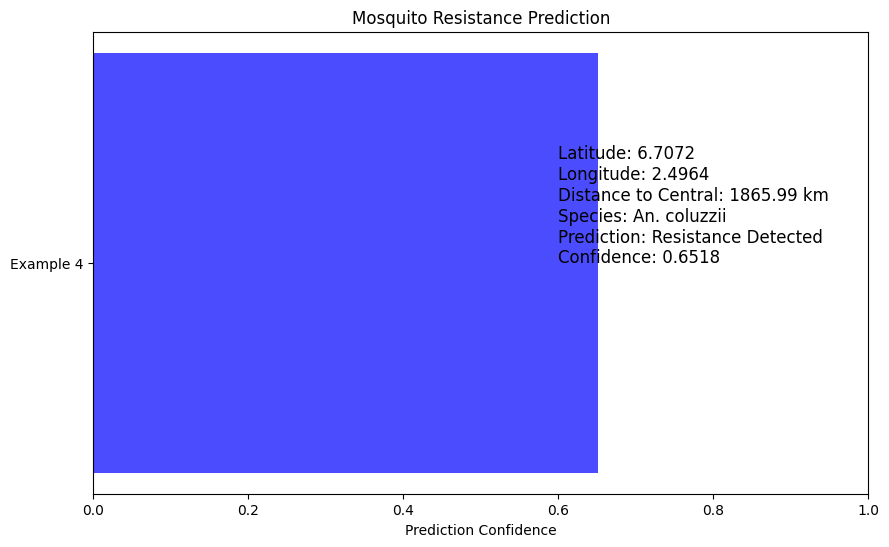

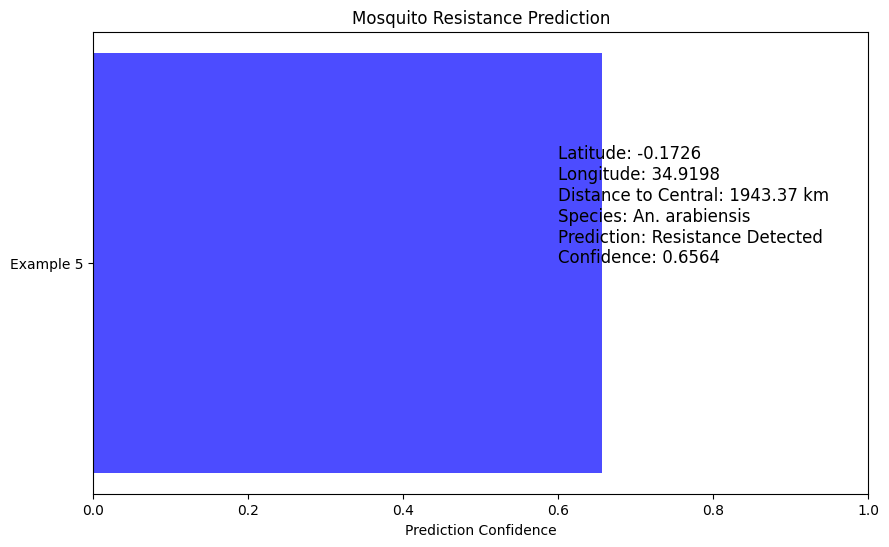

In [81]:
import matplotlib.pyplot as plt
import numpy as np

# Make predictions using the model
predictions = model.predict(np.array([input_1, input_2, input_3, input_4, input_5]))

# Define labels for mosquito resistance
resistance_labels = ["No Resistance Detected", "Resistance Detected"]

# Define example input data (replace with your actual data)
input_data = [
    {"Latitude": 6.5333, "Longitude": 2.6667, "Distance to Central": 1849.032399893325, "Species": "An. gambiae s.l."},
    {"Latitude": 6.5333, "Longitude": 2.6667, "Distance to Central": 1849.032399893325, "Species": "An. gambiae s.l."},
    {"Latitude": 6.7072, "Longitude": 2.4964, "Distance to Central": 1865.9928709396627, "Species": "An. coluzzii"},
    {"Latitude": 6.7072, "Longitude": 2.4964, "Distance to Central": 1865.9928709396627, "Species": "An. coluzzii"},
    {"Latitude": -0.1726, "Longitude": 34.9198, "Distance to Central": 1943.372389926523, "Species": "An. arabiensis"},
]

# Interpret and print the predictions with additional information
for i, pred in enumerate(predictions):
    plt.figure(figsize=(10, 6))
    plt.barh([f"Example {i + 1}"], [pred[0]], color='blue', alpha=0.7)
    plt.xlim(0, 1)
    plt.xlabel("Prediction Confidence")
    plt.title("Mosquito Resistance Prediction")
    
    # Display prediction and additional information as text on the plot
    text = f"Latitude: {input_data[i]['Latitude']:.4f}\n"
    text += f"Longitude: {input_data[i]['Longitude']:.4f}\n"
    text += f"Distance to Central: {input_data[i]['Distance to Central']:.2f} km\n"
    text += f"Species: {input_data[i]['Species']}\n"
    text += f"Prediction: {resistance_labels[1] if pred >= 0.5 else resistance_labels[0]}\n"
    text += f"Confidence: {pred[0]:.4f}"
    
    plt.text(0.6, 0.5, text, fontsize=12, transform=plt.gca().transAxes)
    
    plt.show()
